_Solar Wind Width_
====================
We wish to analyze the correlation between solar wind observed at THEMIS-D and THEMIS-B for different x-distances off the Earth-Sun line. The code finds the correlation between the two of them and also computes both the x- and y- offsets of the spacecraft

In [2]:
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.optimize import curve_fit
import datetime as dt
from datetime import timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from mpl_toolkits import mplot3d

In [3]:
def importField(path): #Function to import the magnetic field data
    b_field = np.loadtxt(path, usecols=(1,2,3), skiprows=1, delimiter=',') #Load csv file with B-field from the FGM
    f_times = np.loadtxt(path, dtype='str', usecols=0, skiprows=1, delimiter=',') #Load the time series for the FGM

    field_times = []
    for i in range(len(f_times)): #Convert the strings into datetime objects
        field_times.append(dt.datetime.strptime(f_times[i], '%Y-%m-%dT%H:%M:%S.%fZ'))

    return [b_field, field_times]

In [4]:
def importOrbit(path): #Function to import the orbit parameters
    orbit = np.loadtxt(path, usecols=(1,2,3), skiprows=1, delimiter=',') #Load csv file with x, y, z locations
    o_times = np.loadtxt(path, dtype='str', usecols=0, skiprows=1, delimiter=',') #Load the time series for the orbit

    orbit_times = []
    for j in range(len(o_times)): #Convert the strings into datetime objects
        orbit_times.append(dt.datetime.strptime(o_times[j], '%Y-%m-%dT%H:%M:%S.%fZ'))

    return [orbit, orbit_times]

In [5]:
#Creates the dictionary of FGM data. It is separated into "bowshock" and "moon" keys for THEMIS-A, -D, -E and Themis-B
fgm = {
    '2011-10-24':{
        'bowshock': importField("Data/2011-10-24/THA_FGM.csv"), #Calls the import field function from above
        'moon' : importField("Data/2011-10-24/THB_FGM.csv") #And returns the X, Y, Z components and raw time series
    },
    '2011-12-28':{
        'bowshock': importField("Data/2011-12-28/THE_FGM.csv"),
        'moon' : importField("Data/2011-12-28/THB_FGM.csv")
    },
    '2013-01-17':{
        'bowshock': importField("Data/2013-01-17/THD_FGM.csv"),
        'moon' : importField("Data/2013-01-17/THB_FGM.csv")
    },
    '2014-02-27A':{
        'bowshock': importField("Data/2014-02-27A/THD_FGM.csv"),
        'moon' : importField("Data/2014-02-27A/THB_FGM.csv")
    },
    '2014-02-27B':{
        'bowshock': importField("Data/2014-02-27B/THD_FGM.csv"),
        'moon' : importField("Data/2014-02-27B/THB_FGM.csv")
    },
    '2014-04-05':{
        'bowshock': importField("Data/2014-04-05/THD_FGM.csv"),
        'moon' : importField("Data/2014-04-05/THB_FGM.csv")
    },
    '2015-03-16':{
        'bowshock': importField("Data/2015-03-16/THD_FGM.csv"),
        'moon' : importField("Data/2015-03-16/THB_FGM.csv")
    },
    '2015-03-17':{
        'bowshock': importField("Data/2015-03-17/THE_FGM.csv"),
        'moon' : importField("Data/2015-03-17/THB_FGM.csv")
    },
    '2017-09-15':{
        'bowshock': importField("Data/2017-09-15/THE_FGM.csv"),
        'moon': importField("Data/2017-09-15/THB_FGM.csv")
    },
    '2015-04-20':{
        'bowshock': importField("Data/2015-04-20/THA_FGM.csv"),
        'moon': importField("Data/2015-04-20/THB_FGM.csv")
    },
    '2015-06-12':{
        'bowshock': importField("Data/2015-06-12/THA_FGM.csv"),
        'moon': importField("Data/2015-06-12/THB_FGM.csv")
    },
    '2016-06-05':{
        'bowshock': importField("Data/2016-06-05/THD_FGM.csv"),
        'moon' : importField("Data/2016-06-05/THB_FGM.csv")
    },
    '2018-10-09':{
        'bowshock': importField("Data/2018-10-09/THD_FGM.csv"),
        'moon' : importField("Data/2018-10-09/THB_FGM.csv")
    },
    '2019-11-27':{
        'bowshock': importField("Data/2019-11-27/THD_FGM.csv"),
        'moon': importField("Data/2019-11-27/THB_FGM.csv")
    },
    '2016-08-02':{
        'bowshock': importField("Data/2016-08-02/THE_FGM.csv"),
        'moon': importField("Data/2016-08-02/THB_FGM.csv")
    },
    '2017-09-27':{
        'bowshock': importField("Data/2017-09-27/THA_FGM.csv"),
        'moon': importField("Data/2017-09-27/THB_FGM.csv")
    },
    '2018-09-13':{
        'bowshock': importField("Data/2018-09-13/THD_FGM.csv"),
        'moon': importField("Data/2018-09-13/THB_FGM.csv")
    }
}

In [6]:
#Creates a dictionary of the orbit coordinates. "Bowshock" is the close satellite, "moon" is the far one (THEMIS-B).
orbit = {
    '2011-10-24':{
        'bowshock': importOrbit("Data/2011-10-24/THA_OR.csv"), #Calls the import orbit function
        'moon': importOrbit("Data/2011-10-24/THB_OR.csv") #And returns the X, Y, Z array and a time series array
    },
    '2011-12-28':{
        'bowshock': importOrbit("Data/2011-12-28/THE_OR.csv"),
        'moon': importOrbit("Data/2011-12-28/THB_OR.csv")
    },
    '2013-01-17':{
        'bowshock': importOrbit("Data/2013-01-17/THD_OR.csv"),
        'moon': importOrbit("Data/2013-01-17/THB_OR.csv")
    },
    '2014-02-27A':{
        'bowshock': importOrbit("Data/2014-02-27A/THD_OR.csv"),
        'moon': importOrbit("Data/2014-02-27A/THB_OR.csv")
    },
    '2014-02-27B':{
        'bowshock': importOrbit("Data/2014-02-27B/THD_OR.csv"),
        'moon': importOrbit("Data/2014-02-27B/THB_OR.csv")
    },
    '2014-04-05':{
        'bowshock': importOrbit("Data/2014-04-05/THD_OR.csv"),
        'moon': importOrbit("Data/2014-04-05/THB_OR.csv")
    },
    '2015-03-16':{
        'bowshock': importOrbit("Data/2015-03-16/THD_OR.csv"),
        'moon': importOrbit("Data/2015-03-16/THB_OR.csv")
    },
    '2015-03-17':{
        'bowshock': importOrbit("Data/2015-03-17/THE_OR.csv"),
        'moon': importOrbit("Data/2015-03-17/THB_OR.csv")
    },
    '2017-09-15':{
        'bowshock': importOrbit("Data/2017-09-15/THE_OR.csv"),
        'moon': importOrbit("Data/2017-09-15/THB_OR.csv")
    },
    '2015-04-20':{
        'bowshock': importOrbit("Data/2015-04-20/THA_OR.csv"),
        'moon': importOrbit("Data/2015-04-20/THB_OR.csv")
    },
    '2015-06-12':{
        'bowshock': importOrbit("Data/2015-06-12/THA_OR.csv"),
        'moon': importOrbit("Data/2015-06-12/THB_OR.csv")
    },
    '2016-06-05':{
        'bowshock': importOrbit("Data/2016-06-05/THD_OR.csv"),
        'moon': importOrbit("Data/2016-06-05/THB_OR.csv")
    },
    '2018-10-09':{
        'bowshock': importOrbit("Data/2018-10-09/THD_OR.csv"),
        'moon': importOrbit("Data/2018-10-09/THB_OR.csv")
    },
    '2019-11-27':{
        'bowshock': importOrbit("Data/2019-11-27/THD_OR.csv"),
        'moon': importOrbit("Data/2019-11-27/THB_OR.csv")
    },
    '2016-08-02':{
        'bowshock': importOrbit("Data/2016-08-02/THE_OR.csv"),
        'moon': importOrbit("Data/2016-08-02/THB_OR.csv")
    },
    '2017-09-27':{
        'bowshock': importOrbit("Data/2017-09-27/THA_OR.csv"),
        'moon': importOrbit("Data/2017-09-27/THB_OR.csv")
    },
    '2018-09-13':{
        'bowshock': importOrbit("Data/2018-09-13/THD_OR.csv"),
        'moon': importOrbit("Data/2018-09-13/THB_OR.csv")
    }
}

In [7]:
def sep(key): #Function to calculate relative spacecraft separations in all three components. Takes a dictionary date key.
    sc1 = orbit[key]['bowshock'][0] #Spacecraft 1 is the close one at the bowshock (x, y, z array)
    sc2 = orbit[key]['moon'][0] #Spacecraft 2 is the far one around the moon (x, y, z array)

    sc2_start = len(sc2[:,0])-len(sc1[:,0]) #Since the THEMIS-B timeseries is longer, we need to start at the index of SC1
    dx = [] #Empty x-separation array
    dy = [] #Empty y-separation array
    dz = [] #Empty z-separation array

    for i in range(len(sc1[:,0])):
        dx.append(np.abs((sc2[sc2_start+i,0]-sc1[i,0]))) #Absolute val of the difference of coordinate in x
        dy.append(np.abs((sc2[sc2_start+i,1]-sc1[i,1]))) #Absolute val of the difference of coordinate in y
        dz.append(np.abs((sc2[sc2_start+i,2]-sc1[i,2]))) #Absolute val of the difference of coordinate in z

    return [dx, dy, dz]

In [8]:
for i in orbit.keys(): #Append each date key with both the x, y, z arrays and the average y-offset of the spacecraft
    orbit[str(i)].update({'average_sep': sep(str(i)), 'x_bin': np.average(sep(str(i))[0]), 'y_bin': np.average(sep(str(i))[1]), 'z_bin': np.average(sep(str(i))[2])})

In [9]:
def average(times, data):
    minute = times[0].minute # Set the current first minute of the data set
    timeAvgs = [] # Create empty array to store the time-averaged values
    avgArr = [] # Create empty storage array
    timeStep = [] # Create empty time step array
    for i in range(len(times)): # Index the values
        if times[i].minute == minute: # If the time of the next value equals the one set for the minute
            avgArr.append(data[i]) # Append this to the storage array
        elif times[i].minute == minute + 1: # If the time of the next value equals the next minute
            #print(avgArr)
            timeAvgs.append(np.average(avgArr)) # Average the storage array and append it to the time-averaged value array
            #print(np.average(avgArr))
            timeStep.append(dt.datetime(times[i-1].year, times[i-1].month, times[i-1].day, times[i-1].hour, times[i-1].minute, 00)) # Create a timestamp for the previous minute centered at 0s to line up with the orbit timestamps
            minute= times[i].minute # Set the new current minute to start averaging over
            avgArr = [] # Clear the storage array
        elif times[i].minute == minute - 59: # This is for rollover: when the next minute is 0
            #print(avgArr)
            timeAvgs.append(np.average(avgArr))
            #print(np.average(avgArr))
            timeStep.append(dt.datetime(times[i-1].year, times[i-1].month, times[i-1].day, times[i-1].hour, times[i-1].minute, 00))
            minute = times[i].minute
            avgArr = []
    return [timeAvgs, timeStep] # Return the time-averaged array and the timestamp array

In [10]:
fgm_avg = {
    '2011-10-24':{
        'bowshock': average(fgm[list(fgm.keys())[0]]['bowshock'][1], fgm[list(fgm.keys())[0]]['bowshock'][0][:,2]),
        'moon' : average(fgm[list(fgm.keys())[0]]['moon'][1], fgm[list(fgm.keys())[0]]['moon'][0][:,2])
    },
    '2011-12-28':{
        'bowshock': average(fgm[list(fgm.keys())[1]]['bowshock'][1], fgm[list(fgm.keys())[1]]['bowshock'][0][:,2]),
        'moon' : average(fgm[list(fgm.keys())[1]]['moon'][1], fgm[list(fgm.keys())[1]]['moon'][0][:,2])
    },
    '2013-01-17':{
        'bowshock': average(fgm[list(fgm.keys())[2]]['bowshock'][1], fgm[list(fgm.keys())[2]]['bowshock'][0][:,2]),
        'moon' : average(fgm[list(fgm.keys())[2]]['moon'][1], fgm[list(fgm.keys())[2]]['moon'][0][:,2])
    },
    '2014-02-27A':{
        'bowshock': average(fgm[list(fgm.keys())[3]]['bowshock'][1], fgm[list(fgm.keys())[3]]['bowshock'][0][:,2]),
        'moon' : average(fgm[list(fgm.keys())[3]]['moon'][1], fgm[list(fgm.keys())[3]]['moon'][0][:,2])
    },
    '2014-02-27B':{
        'bowshock': average(fgm[list(fgm.keys())[4]]['bowshock'][1], fgm[list(fgm.keys())[4]]['bowshock'][0][:,2]),
        'moon' : average(fgm[list(fgm.keys())[4]]['moon'][1], fgm[list(fgm.keys())[4]]['moon'][0][:,2])
    },
    '2014-04-05':{
        'bowshock': average(fgm[list(fgm.keys())[5]]['bowshock'][1], fgm[list(fgm.keys())[5]]['bowshock'][0][:,2]),
        'moon' : average(fgm[list(fgm.keys())[5]]['moon'][1], fgm[list(fgm.keys())[5]]['moon'][0][:,2])
    },
    '2015-03-16':{
        'bowshock': average(fgm[list(fgm.keys())[6]]['bowshock'][1], fgm[list(fgm.keys())[6]]['bowshock'][0][:,2]),
        'moon' : average(fgm[list(fgm.keys())[6]]['moon'][1], fgm[list(fgm.keys())[6]]['moon'][0][:,2])
    },
    '2015-03-17':{
        'bowshock': average(fgm[list(fgm.keys())[7]]['bowshock'][1], fgm[list(fgm.keys())[7]]['bowshock'][0][:,2]),
        'moon' : average(fgm[list(fgm.keys())[7]]['moon'][1], fgm[list(fgm.keys())[7]]['moon'][0][:,2])
    },
    '2017-09-15':{
        'bowshock': average(fgm[list(fgm.keys())[8]]['bowshock'][1], fgm[list(fgm.keys())[8]]['bowshock'][0][:,2]),
        'moon' : average(fgm[list(fgm.keys())[8]]['moon'][1], fgm[list(fgm.keys())[8]]['moon'][0][:,2])
    },
    '2015-04-20':{
        'bowshock': average(fgm[list(fgm.keys())[9]]['bowshock'][1], fgm[list(fgm.keys())[9]]['bowshock'][0][:,2]),
        'moon' : average(fgm[list(fgm.keys())[9]]['moon'][1], fgm[list(fgm.keys())[9]]['moon'][0][:,2])
    },
    '2015-06-12':{
        'bowshock': average(fgm[list(fgm.keys())[10]]['bowshock'][1], fgm[list(fgm.keys())[10]]['bowshock'][0][:,2]),
        'moon' : average(fgm[list(fgm.keys())[10]]['moon'][1], fgm[list(fgm.keys())[10]]['moon'][0][:,2])
    },
    '2016-06-05':{
        'bowshock': average(fgm[list(fgm.keys())[11]]['bowshock'][1], fgm[list(fgm.keys())[11]]['bowshock'][0][:,2]),
        'moon' : average(fgm[list(fgm.keys())[11]]['moon'][1], fgm[list(fgm.keys())[11]]['moon'][0][:,2])
    },
    '2018-10-09':{
        'bowshock': average(fgm[list(fgm.keys())[12]]['bowshock'][1], fgm[list(fgm.keys())[12]]['bowshock'][0][:,2]),
        'moon' : average(fgm[list(fgm.keys())[12]]['moon'][1], fgm[list(fgm.keys())[12]]['moon'][0][:,2])
    },
    '2019-11-27':{
        'bowshock': average(fgm[list(fgm.keys())[13]]['bowshock'][1], fgm[list(fgm.keys())[13]]['bowshock'][0][:,2]),
        'moon' : average(fgm[list(fgm.keys())[13]]['moon'][1], fgm[list(fgm.keys())[13]]['moon'][0][:,2])
    },
    '2016-08-02':{
        'bowshock': average(fgm[list(fgm.keys())[14]]['bowshock'][1], fgm[list(fgm.keys())[14]]['bowshock'][0][:,2]),
        'moon' : average(fgm[list(fgm.keys())[14]]['moon'][1], fgm[list(fgm.keys())[14]]['moon'][0][:,2])
    },
    '2017-09-27':{
        'bowshock': average(fgm[list(fgm.keys())[15]]['bowshock'][1], fgm[list(fgm.keys())[15]]['bowshock'][0][:,2]),
        'moon' : average(fgm[list(fgm.keys())[15]]['moon'][1], fgm[list(fgm.keys())[15]]['moon'][0][:,2])
    },
    '2018-09-13':{
        'bowshock': average(fgm[list(fgm.keys())[16]]['bowshock'][1], fgm[list(fgm.keys())[16]]['bowshock'][0][:,2]),
        'moon' : average(fgm[list(fgm.keys())[16]]['moon'][1], fgm[list(fgm.keys())[16]]['moon'][0][:,2])
    }

}

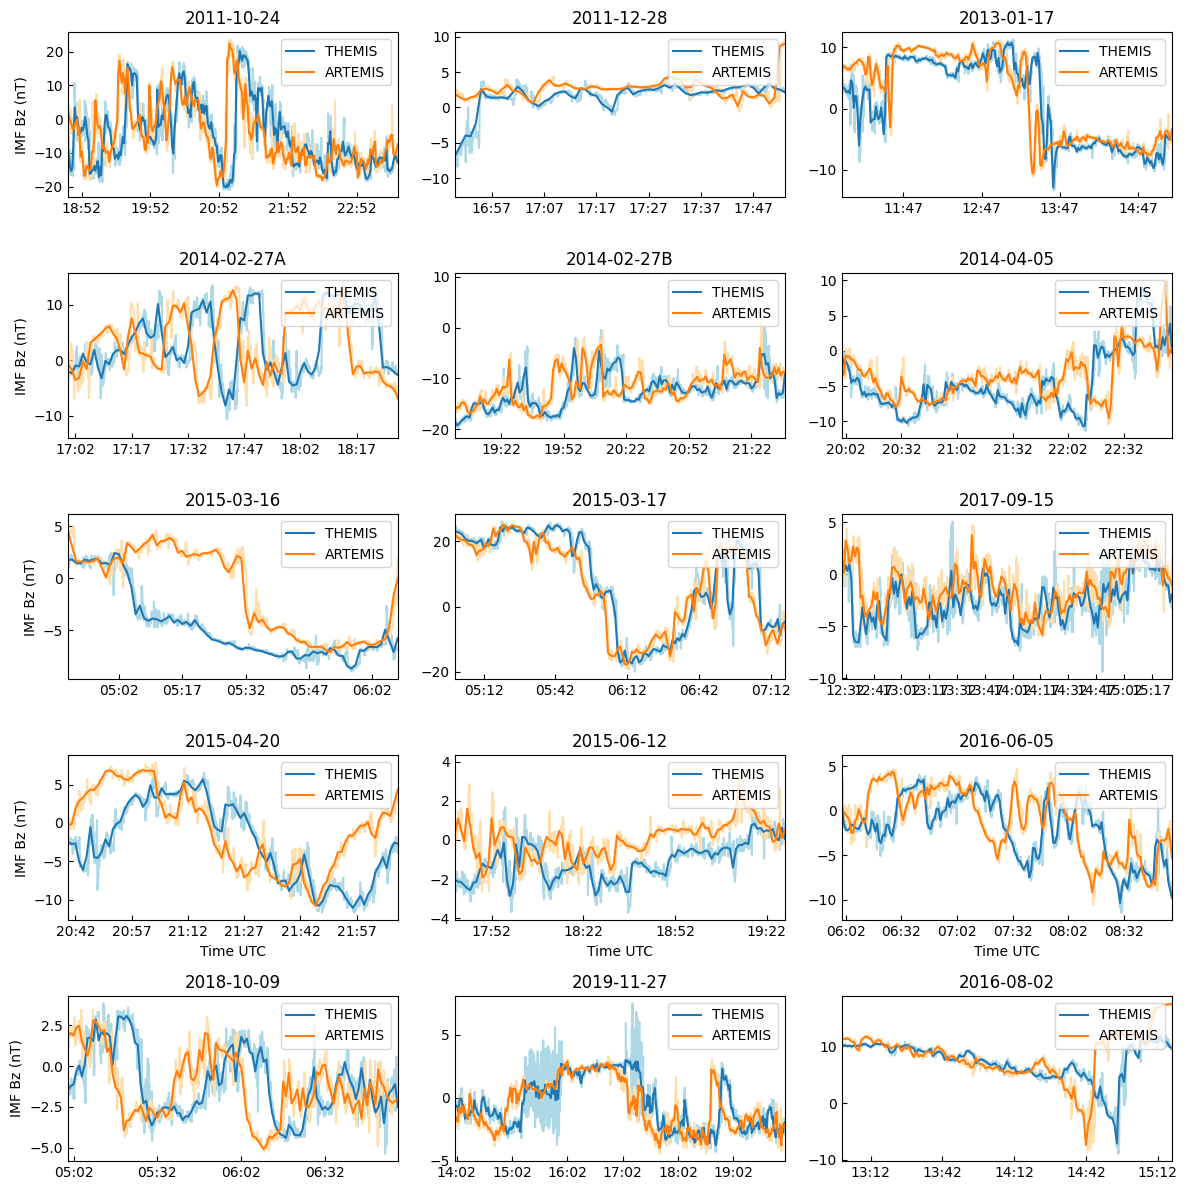

In [143]:
fig, ax = plt.subplots(5,3, figsize=(12,12))

k = 0
for i in range(0,5):
    ax[i,0].set_ylabel("IMF Bz (nT)")
    for j in range(0,3):
        ax[i,j].plot(fgm[list(fgm.keys())[k]]['bowshock'][1], fgm[list(fgm.keys())[k]]['bowshock'][0][:,2], color="lightblue")
        ax[i,j].plot(fgm[list(fgm.keys())[k]]['moon'][1], fgm[list(fgm.keys())[k]]['moon'][0][:,2], color="navajowhite")

        ax[i,j].plot(fgm_avg[list(fgm.keys())[k]]['bowshock'][1], fgm_avg[list(fgm.keys())[k]]['bowshock'][0], color="C0", label="THEMIS")
        ax[i,j].plot(fgm_avg[list(fgm.keys())[k]]['moon'][1], fgm_avg[list(fgm.keys())[k]]['moon'][0], color="C1", label="ARTEMIS")
        ax[i,j].legend(loc="upper right")

        ax[i,j].set_xlim(min(fgm_avg[list(fgm.keys())[k]]['bowshock'][1]), max(fgm_avg[list(fgm.keys())[k]]['bowshock'][1]))
        ax[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax[i,j].xaxis.set_major_locator(mdates.MinuteLocator(interval=60))
        ax[i,j].tick_params(axis='both', direction='in')

        ax[i,j].set_title(list(fgm.keys())[k])
        ax[3,j].set_xlabel("Time UTC")
        k=k+1

ax[0,1].xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
ax[1,0].xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
ax[1,1].xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
ax[1,2].xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
ax[2,0].xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
ax[2,1].xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
ax[2,2].xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
ax[3,0].xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
ax[3,1].xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
ax[3,2].xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
ax[4,0].xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
ax[4,2].xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
plt.tight_layout()
plt.savefig("Plots/IMFs_and_avg.jpg", dpi=300)

In [11]:
def calculate_corrs(key): # Series 1 is the "fixed" series close to Earth, Series 2 is the one we slide
    c=[] # Define a matrix to store correlation coefficient
    x_avg=[]
    y_avg=[]
    z_avg=[]

    series1 = fgm_avg[key]['bowshock'][0]
    series1T = fgm_avg[key]['bowshock'][1]
    series2 = fgm_avg[key]['moon'][0]
    series2T = fgm_avg[key]['moon'][1]

    for j in range(len(series1T) - 59): # Range for the length of the fixed series minus one hour
        a = [] # Temporary storage array
        n2_start = series2T.index(series1T[j])
        n2_stop = series2T.index(series1T[j+59])
        for i in range(30):
            coef = np.corrcoef(series1[j:j+59], series2[n2_start-i:n2_stop-i], 1)[0, 1]
            if coef < 0:
                coef = 0
            a.append(coef)
        c.append(a)

        x_avg.append(np.average(orbit[key]['average_sep'][0][j:j+59]))
        y_avg.append(np.average(orbit[key]['average_sep'][1][j:j+59]))
        z_avg.append(np.average(orbit[key]['average_sep'][2][j:j+59]))
    return c, x_avg, y_avg, z_avg

In [12]:
fgm_corrs = {
    '2011-10-24': calculate_corrs("2011-10-24"),

    '2011-12-28': calculate_corrs("2011-12-28"),

    '2013-01-17': calculate_corrs("2013-01-17"),

    '2014-02-27A': calculate_corrs("2014-02-27A"),

    '2014-02-27B': calculate_corrs("2014-02-27B"),

    '2014-04-05': calculate_corrs("2014-04-05"),

    '2015-03-16': calculate_corrs("2015-03-16"),

    '2015-03-17': calculate_corrs("2015-03-17"),

    '2017-09-15': calculate_corrs("2017-09-15"),

    '2015-04-20': calculate_corrs("2015-04-20"),

    '2015-06-12': calculate_corrs("2015-06-12"),

    '2016-06-05': calculate_corrs("2016-06-05"),

    '2016-08-02': calculate_corrs("2016-08-02"),

    '2018-10-09': calculate_corrs("2018-10-09"),

    '2019-11-27': calculate_corrs("2019-11-27"),

    '2017-09-27': calculate_corrs("2017-09-27"),

    '2018-09-13': calculate_corrs("2018-09-13")
}

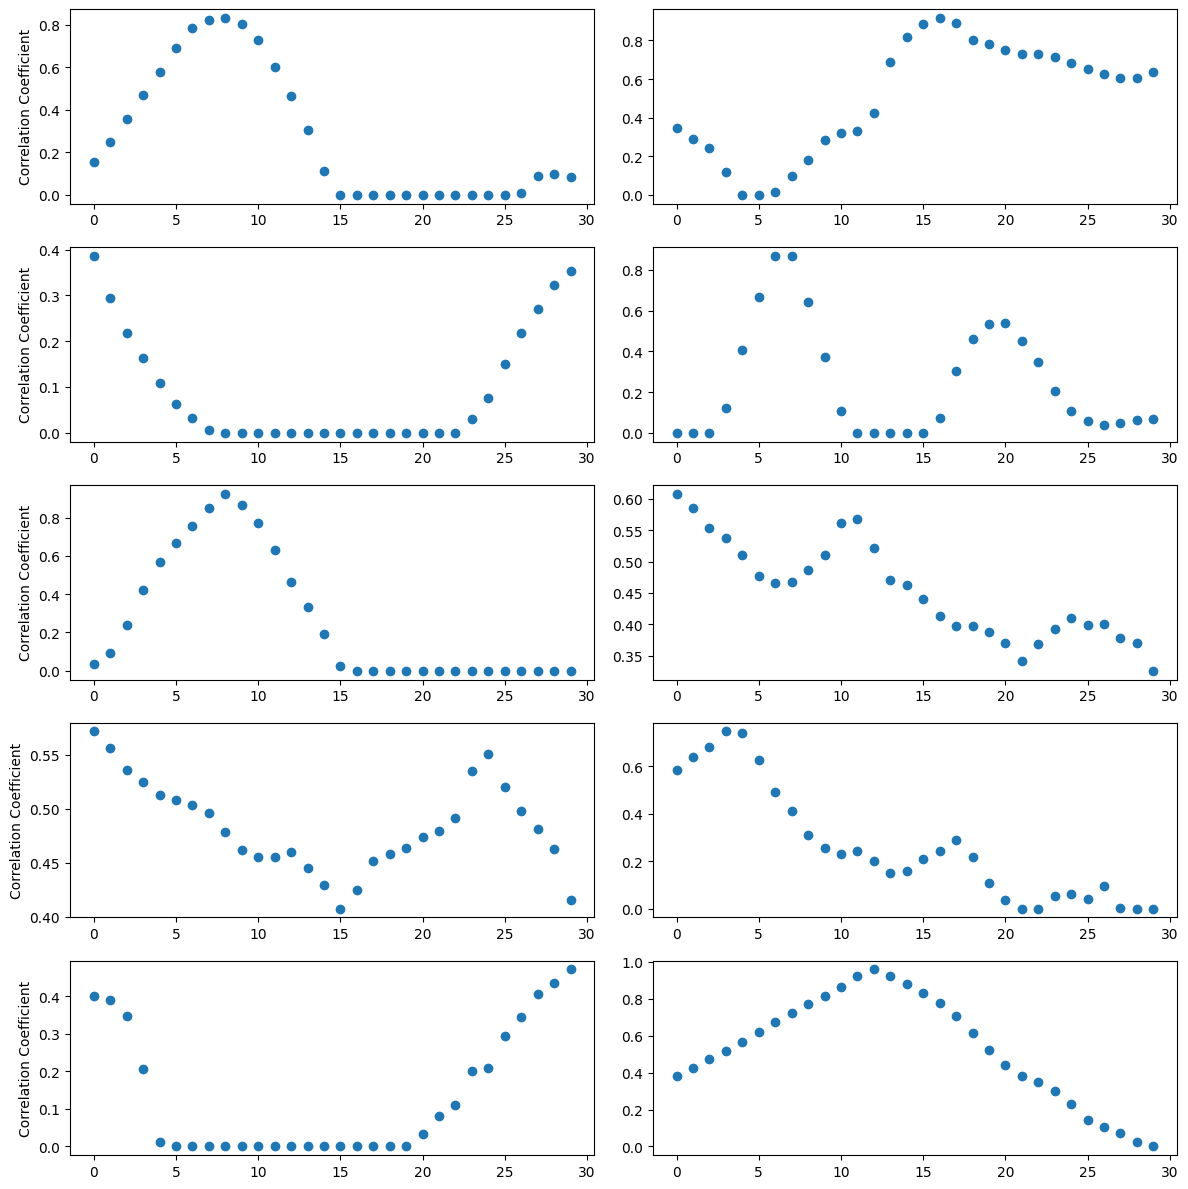

In [146]:
fig, ax = plt.subplots(5,2, figsize=(12, 12))

k = 0
for i in range(0,5):
    ax[i,0].set_ylabel("Correlation Coefficient")
    for j in range(0,2):
        ax[i,j].scatter(np.arange(0, len(fgm_corrs[list(fgm_corrs.keys())[k]][0][0])), fgm_corrs[list(fgm_corrs.keys())[k]][0][0])

        #ax[i,j].set_xlim(min(fgm_avg[list(fgm.keys())[k]]['bowshock'][1]), max(fgm_avg[list(fgm.keys())[k]]['bowshock'][1]))
        #ax[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        #ax[i,j].xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
        #ax[i,j].tick_params(axis='both', direction='in')
        #ax[3,j].set_xlabel("Time UTC")
        k=k+1

#ax[0,1].xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
#ax[1,1].xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
plt.tight_layout()
#plt.savefig("Plots/IMFs_avg.jpg", dpi=300)

In [13]:
def maxingfn(data):
    p_max = []
    offsetx = []
    offsety = []
    offsetz = []
    for i in range(len(data[0])):
        p_max.append(max(data[0][i]))
        offsetx.append(data[1][i])
        offsety.append(data[2][i])
        offsetz.append(data[3][i])
    return [p_max, offsetx, offsety, offsetz]

pmax = {
    '2011-10-24': maxingfn(fgm_corrs['2011-10-24']),
    '2011-12-28': maxingfn(fgm_corrs['2011-12-28']),
    '2013-01-17': maxingfn(fgm_corrs['2013-01-17']),
    '2014-02-27A': maxingfn(fgm_corrs['2014-02-27A']),
    '2014-02-27B': maxingfn(fgm_corrs['2014-02-27B']),
    '2014-04-05': maxingfn(fgm_corrs['2014-04-05']),
    '2015-03-16': maxingfn(fgm_corrs['2015-03-16']),
    '2015-03-17': maxingfn(fgm_corrs['2015-03-17']),
    '2017-09-15': maxingfn(fgm_corrs['2017-09-15']),
    '2015-04-20': maxingfn(fgm_corrs['2015-04-20']),
    '2015-06-12': maxingfn(fgm_corrs['2015-06-12']),
    '2016-06-05': maxingfn(fgm_corrs['2016-06-05']),
    '2016-08-02': maxingfn(fgm_corrs['2016-08-02']),
    '2018-10-09': maxingfn(fgm_corrs['2018-10-09']),
    '2019-11-27': maxingfn(fgm_corrs['2019-11-27']),
    '2017-09-27': maxingfn(fgm_corrs['2017-09-27']),
    '2018-09-13': maxingfn(fgm_corrs['2018-09-13'])
}

In [14]:
bin = [0,0,0,0,0,0,0,0,0,0,0]
for k in range(17):
    for i in range(len(pmax[list(pmax.keys())[k]][0])):
        if 0 <= pmax[list(pmax.keys())[k]][0][i] < 0.1:
            bin[0] = bin[0] + 1
        elif 0.1 <= pmax[list(pmax.keys())[k]][0][i] <0.2:
            bin[1] = bin[1] + 1
        elif 0.2 <= pmax[list(pmax.keys())[k]][0][i] <0.3:
            bin[2] = bin[2] + 1
        elif 0.3 <= pmax[list(pmax.keys())[k]][0][i] <0.4:
            bin[3] = bin[3] + 1
        elif 0.4 <= pmax[list(pmax.keys())[k]][0][i] <0.5:
            bin[4] = bin[4] + 1
        elif 0.5 <= pmax[list(pmax.keys())[k]][0][i] <0.6:
            bin[5] = bin[5] + 1
        elif 0.6 <= pmax[list(pmax.keys())[k]][0][i] <0.7:
            bin[6] = bin[6] + 1
        elif 0.7 <= pmax[list(pmax.keys())[k]][0][i] <0.8:
            bin[7] = bin[7] + 1
        elif 0.8 <= pmax[list(pmax.keys())[k]][0][i] <0.9:
            bin[8] = bin[8] + 1
        elif 0.9 <= pmax[list(pmax.keys())[k]][0][i] <1:
            bin[9] = bin[9] + 1

In [15]:
totalpts = 0
for k in range(17):
    totalpts = totalpts + len(pmax[list(pmax.keys())[k]][0])

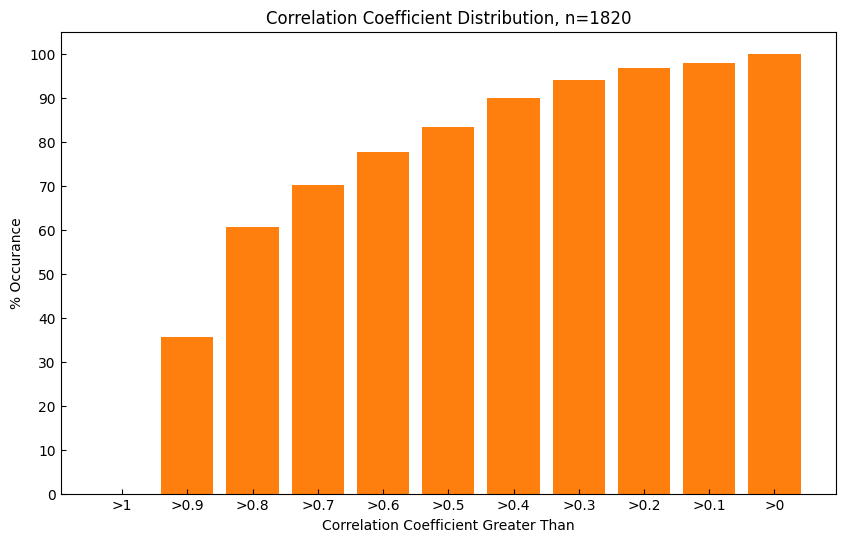

In [16]:
fig, ax = plt.subplots(figsize = (10,6))

bins = [">1", ">0.9", ">0.8", ">0.7", ">0.6", ">0.5", ">0.4", ">0.3", ">0.2", ">0.1", ">0"]
heights1 = [(np.sum(bin[10])/totalpts)*100, (np.sum(bin[9:10])/totalpts)*100, (np.sum(bin[8:10])/totalpts)*100, (np.sum(bin[7:10])/totalpts)*100, (np.sum(bin[6:10])/totalpts)*100, (np.sum(bin[5:10])/totalpts)*100, (np.sum(bin[4:10])/totalpts)*100, (np.sum(bin[3:10])/totalpts)*100, (np.sum(bin[2:10])/totalpts)*100, (np.sum(bin[1:10])/totalpts)*100, (np.sum(bin[0:10])/totalpts)*100]

ax.bar(bins, heights1, color='C1')


ax.set_ylabel("% Occurance")
ax.set_xlabel("Correlation Coefficient Greater Than")
ax.set_title("Correlation Coefficient Distribution, n="+str(totalpts))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.tick_params(axis='both', direction='in')

plt.savefig("Plots/Corrs.jpg", dpi=300)

In [17]:
def counting(input_num, bin):
    if 0 <= input_num < 0.1:
        bin[0] = bin[0] + 1
    elif 0.1 <= input_num <0.2:
        bin[1] = bin[1] + 1
    elif 0.2 <= input_num <0.3:
        bin[2] = bin[2] + 1
    elif 0.3 <= input_num <0.4:
        bin[3] = bin[3] + 1
    elif 0.4 <= input_num <0.5:
        bin[4] = bin[4] + 1
    elif 0.5 <= input_num <0.6:
        bin[5] = bin[5] + 1
    elif 0.6 <= input_num <0.7:
        bin[6] = bin[6] + 1
    elif 0.7 <= input_num <0.8:
        bin[7] = bin[7] + 1
    elif 0.8 <= input_num <0.9:
        bin[8] = bin[8] + 1
    elif 0.9 <= input_num <1:
        bin[9] = bin[9] + 1

In [18]:
zeroToTwenty = [0,0,0,0,0,0,0,0,0,0,0]
ztt = 0
twentyToFourty = [0,0,0,0,0,0,0,0,0,0,0]
ttf = 0
fourtyToSixty = [0,0,0,0,0,0,0,0,0,0,0]
fts = 0
sixtyPlus = [0,0,0,0,0,0,0,0,0,0,0]
sp = 0

for k in range(17):
    for i in range(len(pmax[list(pmax.keys())[k]][0])):
        if 0 <= pmax[list(pmax.keys())[k]][2][i] < 20:
            counting(pmax[list(pmax.keys())[k]][0][i], zeroToTwenty)
            ztt = ztt + 1
        elif 20 <= pmax[list(pmax.keys())[k]][2][i] < 40:
            counting(pmax[list(pmax.keys())[k]][0][i], twentyToFourty)
            ttf = ttf + 1
        elif 40 <= pmax[list(pmax.keys())[k]][2][i] < 60:
            counting(pmax[list(pmax.keys())[k]][0][i], fourtyToSixty)
            fts = fts + 1
        elif 60 <= pmax[list(pmax.keys())[k]][2][i]:
            counting(pmax[list(pmax.keys())[k]][0][i], sixtyPlus)
            sp = sp + 1

In [19]:
bin_corrs={
    'zeroToTwenty' : [zeroToTwenty, ztt],
    'twentyToFourty' : [twentyToFourty, ttf],
    'fourtyToSixty' : [fourtyToSixty, fts],
    'sixtyPlus' : [sixtyPlus, sp]
}

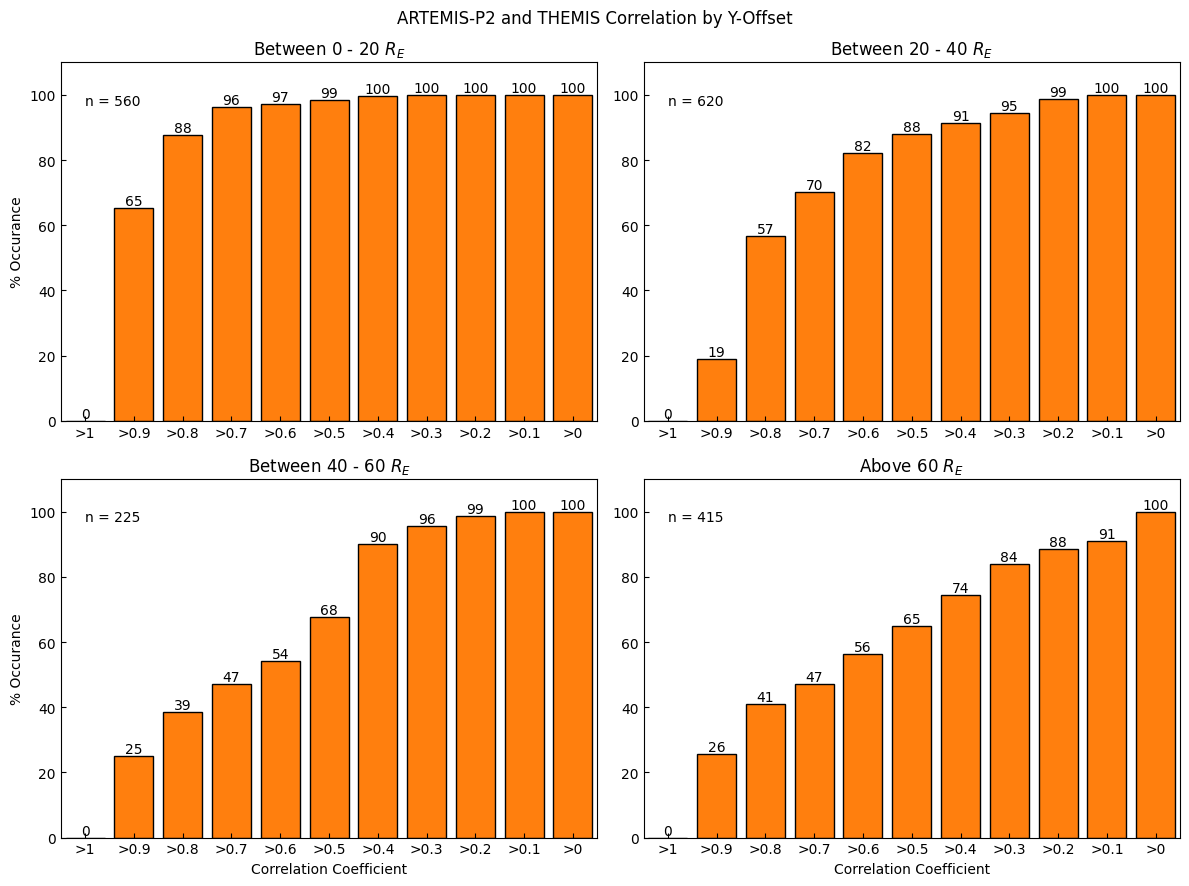

In [30]:
fig, ax = plt.subplots(2,2, figsize=(12,9))

bins = [">1", ">0.9", ">0.8", ">0.7", ">0.6", ">0.5", ">0.4", ">0.3", ">0.2", ">0.1", ">0"]
k = 0

for i in range(0,2):
    for j in range(0,2):
        heights = [(np.sum(bin_corrs[list(bin_corrs.keys())[k]][0][10])/bin_corrs[list(bin_corrs.keys())[k]][1])*100, (np.sum(bin_corrs[list(bin_corrs.keys())[k]][0][9:10])/bin_corrs[list(bin_corrs.keys())[k]][1])*100, (np.sum(bin_corrs[list(bin_corrs.keys())[k]][0][8:10])/bin_corrs[list(bin_corrs.keys())[k]][1])*100, (np.sum(bin_corrs[list(bin_corrs.keys())[k]][0][7:10])/bin_corrs[list(bin_corrs.keys())[k]][1])*100, (np.sum(bin_corrs[list(bin_corrs.keys())[k]][0][6:10])/bin_corrs[list(bin_corrs.keys())[k]][1])*100, (np.sum(bin_corrs[list(bin_corrs.keys())[k]][0][5:10])/bin_corrs[list(bin_corrs.keys())[k]][1])*100, (np.sum(bin_corrs[list(bin_corrs.keys())[k]][0][4:10])/bin_corrs[list(bin_corrs.keys())[k]][1])*100, (np.sum(bin_corrs[list(bin_corrs.keys())[k]][0][3:10])/bin_corrs[list(bin_corrs.keys())[k]][1])*100, (np.sum(bin_corrs[list(bin_corrs.keys())[k]][0][2:10])/bin_corrs[list(bin_corrs.keys())[k]][1])*100, (np.sum(bin_corrs[list(bin_corrs.keys())[k]][0][1:10])/bin_corrs[list(bin_corrs.keys())[k]][1])*100, (np.sum(bin_corrs[list(bin_corrs.keys())[k]][0][0:10])/bin_corrs[list(bin_corrs.keys())[k]][1])*100]

        #ax[i,j].set_xlim(min(fgm_avg[list(fgm.keys())[k]]['bowshock'][1]), max(fgm_avg[list(fgm.keys())[k]]['bowshock'][1]))
        #ax[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax[i,j].text(0, 97, "n = "+str(bin_corrs[list(bin_corrs.keys())[k]][1]))
        ax[i,j].tick_params(axis='both', direction='in')
        ax[i,j].set_xlim(-0.5, 10.5)
        ax[i,j].set_ylim(0, 110)
        ax[i,0].set_ylabel("% Occurance")
        ax[1,j].set_xlabel("Correlation Coefficient")
        k=k+1

        bars = ax[i,j].bar(bins, heights, color='C1', width=0.8, edgecolor="black")
        ax[i,j].bar_label(bars, fmt='%.0f')

ax[0,0].set_title('Between 0 - 20 ' r'$R_E$')
ax[0,1].set_title("Between 20 - 40 " r'$R_E$')
ax[1,0].set_title("Between 40 - 60 " r'$R_E$')
ax[1,1].set_title("Above 60 " r'$R_E$')

plt.suptitle("ARTEMIS-P2 and THEMIS Correlation by Y-Offset")
plt.tight_layout()
plt.savefig("Plots/BarsByY", dpi=300)

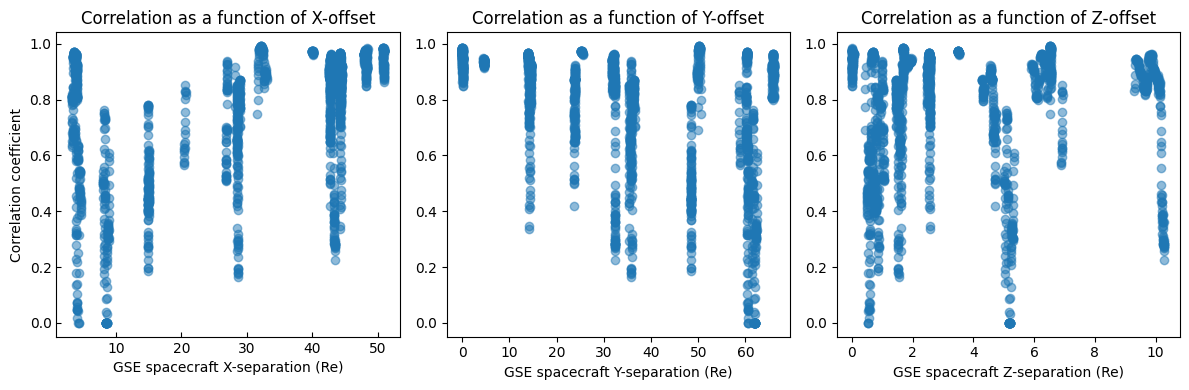

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))

ax[0].set_title("Correlation as a function of X-offset")
ax[0].set_xlabel("GSE spacecraft X-separation (Re)")

ax[1].set_title("Correlation as a function of Y-offset")
ax[1].set_xlabel("GSE spacecraft Y-separation (Re)")

ax[2].set_title("Correlation as a function of Z-offset")
ax[2].set_xlabel("GSE spacecraft Z-separation (Re)")

ax[0].set_ylabel("Correlation coefficient")
ax[0].tick_params(axis="both", direction="in")

for i in pmax.keys():
    for j in range(len(pmax[i][0])):
        ax[0].scatter(pmax[i][1][j], pmax[i][0][j], color="C0", alpha=0.5)
        ax[1].scatter(pmax[i][2][j], pmax[i][0][j], color="C0", alpha=0.5)
        ax[2].scatter(pmax[i][3][j], pmax[i][0][j], color="C0", alpha=0.5)

plt.tight_layout()
plt.savefig("Plots/Points.jpg", dpi=300)

In [22]:
def weighted_corrs(keys):
    start = int(keys[1][0])
    store = []
    avgs = []
    offsets = []
    for i in range(len(keys[1])):
        if int(keys[1][i]) == start:
            store.append(keys[0][i])
        elif int(keys[1][i]) != start:
            avgs.append(np.average(store))
            offsets.append(start)

            store = []
            store.append(keys[0][i])
            start = int(keys[1][i])
    avgs.append(np.average(store))
    offsets.append(start)
    return [avgs, offsets]

In [28]:
keys = ['2011-10-24', '2011-12-28', '2013-01-17', '2014-02-27A', '2014-02-27B', '2014-04-05','2015-03-16', '2015-03-17',  '2017-09-15', '2015-04-20', '2015-06-12', '2016-06-05', '2016-08-02', '2018-10-09', '2019-11-27', '2018-09-13']

#keys = ['2011-10-24', '2011-12-28', '2013-01-17', '2014-02-27A', '2014-02-27B', '2014-04-05','2015-03-16', '2015-03-17',  '2017-09-15', '2015-04-20', '2015-06-12', '2016-06-05', '2016-08-02', '2018-10-09', '2019-11-27']


maxes = []
sepx = []
sepy = []
sepz = []

for i in keys:
    maxes = np.concatenate((maxes, pmax[i][0]))
    sepx = np.concatenate((sepx, pmax[i][1]))
    sepy = np.concatenate((sepy, pmax[i][2]))
    sepz = np.concatenate((sepz, pmax[i][3]))
allx = [maxes, sepx]
ally = [maxes, sepy]
allz = [maxes, sepz]

osavgx = weighted_corrs(allx)
osavgy = weighted_corrs(ally)
osavgz = weighted_corrs(allz)

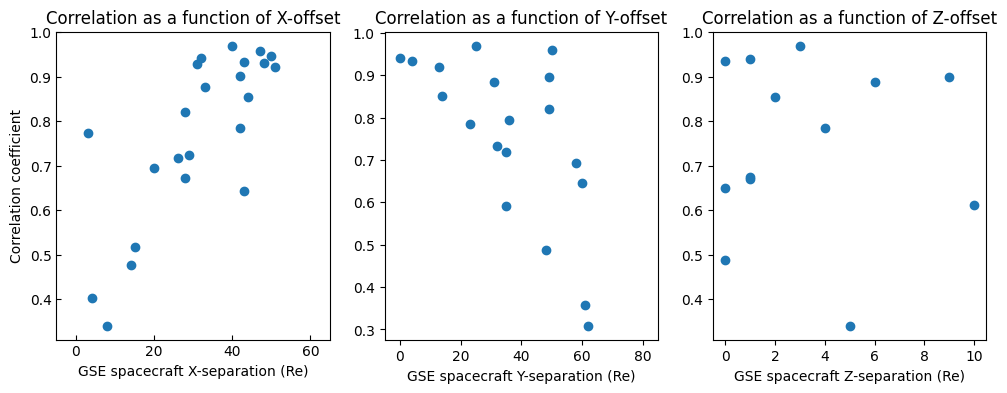

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))
ax[0].set_title("Correlation as a function of X-offset")
ax[1].set_title("Correlation as a function of Y-offset")
ax[2].set_title("Correlation as a function of Z-offset")

ax[0].set_xlabel("GSE spacecraft X-separation (Re)")
ax[1].set_xlabel("GSE spacecraft Y-separation (Re)")
ax[2].set_xlabel("GSE spacecraft Z-separation (Re)")

ax[0].set_ylabel("Correlation coefficient")
ax[0].tick_params(axis="both", direction="in")

ax[0].scatter(osavgx[1], osavgx[0], color="C0")
ax[1].scatter(osavgy[1], osavgy[0], color="C0")
ax[2].scatter(osavgz[1], osavgz[0], color="C0")

ax[0].set_xlim(-5, 65)
ax[1].set_xlim(-5, 85)

plt.tight_layout
plt.savefig("Plots/AvgPoints.jpg", dpi=300)